# What changed on Volcán de Agua during the July seismic swarm?

We analyze **Sentinel-1 VV backscatter (dB)** to detect surface changes **before**, **during**, and **after** a one-week seismic swarm around Volcán de Agua (Sacatepéquez, Guatemala).  
This is a fast **surface-change screening** (texture/moisture) rather than an InSAR displacement product.


In [28]:
pip install earthengine-api


## Environment setup

We install and import the tools needed for Google Earth Engine and mapping.  
If you re-run the notebook from scratch, keep the install cells at the top so the rest of the analysis runs cleanly.


In [29]:
import ee
ee.Authenticate()
ee.Initialize(project="spaceapps-474219")


## Data & study area

- **Sensor / product:** Sentinel-1 **GRD**, mode **IW**, polarization **VV**  
- **AOI:** Summit and flanks of Volcán de Agua  
- **Time windows:**  
  - **Before** — the month preceding the swarm  
  - **During** — the week/month of the swarm  
  - **After** — the weeks following the swarm  
- **Basemaps:** hillshade (SRTM) and/or satellite imagery for topographic context


In [30]:
!pip install geemap

In [31]:
pip install earthaccess

## Why GRD (VV) and not InSAR?

GRD change maps are excellent for **quick, area-wide screening** of **surface roughness/moisture** changes.  
To reproduce **LOS displacement/velocity** like in research papers, you need **SLC** pairs on the same relative orbit and an InSAR time-series pipeline (MintPy/SNAP/GAMMA). Here we focus on **surface-change signals** that help triage where to look deeper.


In [33]:


import earthaccess

# Te pedirá login en una ventanita/console output en Colab
auth = earthaccess.login(strategy="interactive")

# Ejemplo: buscar Sentinel-1 en Palín
results = earthaccess.search_data(
    short_name="SENTINEL-1A_SLC",
    bounding_box=(-90.65, 14.35, -90.55, 14.45),  # aprox Palín, Escuintla
    temporal=("2025-07-01", "2025-08-01")
)

print("Granules encontrados:", len(results))

Granules encontrados: 7


In [34]:
!pip -q install gdown
!gdown --folder "https://drive.google.com/drive/folders/1zYJtbaXojJLwrYE4HmrGTI8H7-5x0Ty3?usp=sharing" -O /content/datos_sar

# Verifica
!ls -R /content/datos_sar | head -n 200




Retrieving folder contents
Retrieving folder 1JBYGzdncUflcMAToV3VV7Z-aHBK1f0Wd Calibration
Processing file 1QrKvI2G-DED6OoFeFweJ5Lp9HeW4EE7b Copia de calibration-s1a-iw1-slc-vh-20250701t001439-20250701t001504-059883-077026-001.xml
Processing file 1S_PYh5Lo3CKrnFl259zzmNLoOu02UgKU Copia de calibration-s1a-iw1-slc-vh-20250903t115446-20250903t115505-060823-079297-001.xml
Processing file 1gsIv2m-wkZbve2WFIDf5KQmzyDUPL1B4 Copia de calibration-s1a-iw1-slc-vh-20250911t001439-20250911t001504-060933-0796f3-001.xml
Processing file 1CmoQ0cGg7sVAqD1nyTu8-mwUeNJHnxVD Copia de calibration-s1a-iw1-slc-vh-20250923t001439-20250923t001504-061108-079df3-001.xml
Processing file 1-YTAU0zIaY6lW89UjyZe_830IZ8qqnV5 Copia de calibration-s1a-iw1-slc-vh-20250927t115446-20250927t115506-061173-07a0a1-001.xml
Processing file 1PZYYfZ-5CxW0EsVRO80iEN05Mxw0PbeW Copia de calibration-s1a-iw1-slc-vv-20250903t115446-20250903t115505-060823-079297-004.xml
Processing file 1VRM1LLdFOcX6KUedKVWDqxkS7oMrXXcD Copia de calibratio

Total imágenes: 30


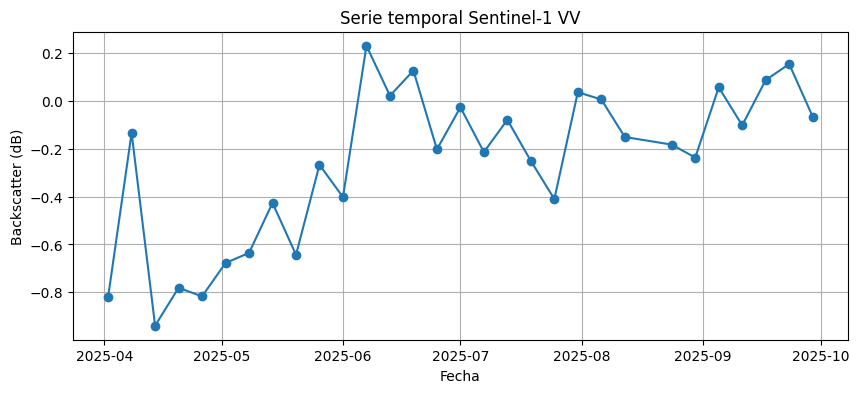

In [35]:
import ee, pandas as pd, matplotlib.pyplot as plt


# 1. Define área de interés (ejemplo: polígono en Guatemala)
aoi = ee.Geometry.Rectangle([-90.8, 14.4, -90.7, 14.5])

# 2. Filtrar colección Sentinel-1 GRD
collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
              .filterBounds(aoi)
              .filterDate('2025-04-01','2025-10-05')
              .filter(ee.Filter.eq('instrumentMode','IW'))
              .filter(ee.Filter.eq('orbitProperties_pass','ASCENDING'))
              .select('VV'))

print("Total imágenes:", collection.size().getInfo())

# 3. Extraer media dB sobre AOI
def to_feature(img):
    date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
    db = img.log10().multiply(10)  # convertir a dB
    mean = db.reduceRegion(ee.Reducer.mean(), aoi, 30).get('VV')
    return ee.Feature(None, {'date': date, 'mean_db': mean})

features = collection.map(to_feature).filter(ee.Filter.notNull(['mean_db'])).getInfo()

# 4. Pasar a pandas
rows = [{'date': f['properties']['date'],
         'mean_db': f['properties']['mean_db']} for f in features['features']]
df = pd.DataFrame(rows)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 5. Graficar
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['mean_db'], marker='o')
plt.title("Serie temporal Sentinel-1 VV")
plt.xlabel("Fecha")
plt.ylabel("Backscatter (dB)")
plt.grid(True)
plt.show()

## Time-series sanity check

We compute per-image VV (dB) averages over the AOI to make sure data availability and backscatter levels are stable.  
This provides context before we collapse each period into a median composite.


## Before / During / After composites (map)

Here we build the three **median** VV(dB) images, apply a consistent stretch, and display them with optional change layers on an interactive map.  
Use the layer toggles to compare the three epochs and to preview Δ dB behavior.


In [42]:
# ==== Sentinel-1: visualización agradable (antes/durante/después + cambio dB con basemap) ====
import ee, geemap
from IPython.display import display

# 1) Configura tu AOI y ventanas
aoi = ee.Geometry.Rectangle([-90.8, 14.4, -90.7, 14.5])  # Zacatepequez
dates = {
    "before":  ("2025-06-01", "2025-06-30"),
    "during":  ("2025-07-01", "2025-07-31"),
    "after":   ("2025-08-01", "2025-10-05"),
}
ORBIT = "ASCENDING"   # prueba "DESCENDING" si no te cuadra el solape

# 2) Utilidades
def s1_vv_linear(aoi, start, end, orbit="ASCENDING"):
    """ Devuelve mediana en LINEAL (sigma0) con mascarado básico. """
    col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filterBounds(aoi)
           .filterDate(start, end)
           .filter(ee.Filter.eq("instrumentMode","IW"))
           .filter(ee.Filter.eq("orbitProperties_pass", orbit))
           .filter(ee.Filter.listContains("transmitterReceiverPolarisation","VV"))
           .select("VV"))
    img_lin = col.median().updateMask(col.median().gt(1e-4))  # evita log(0) más adelante
    return img_lin.clip(aoi), col.size()

def boxcar_linear(img_lin, radius_m=30):
    """ Suavizado simple en LINEAL (reduce speckle). """
    return img_lin.focal_mean(radius=radius_m, units="meters").rename("VV")

def to_db(img_lin):
    return img_lin.log10().multiply(10).rename("VV_dB")

def diff_db(dbA, dbB):
    return dbB.subtract(dbA).rename("dB_change")

# 3) Construir compositos con suave leve y convertir a dB
before_lin, nB = s1_vv_linear(aoi, *dates["before"], orbit=ORBIT)
during_lin, nD = s1_vv_linear(aoi, *dates["during"], orbit=ORBIT)
after_lin,  nA = s1_vv_linear(aoi, *dates["after"],  orbit=ORBIT)

# Suavizado (reduce grano sin perder estructura grande)
before_db = to_db(boxcar_linear(before_lin, 30))
during_db = to_db(boxcar_linear(during_lin, 30))
after_db  = to_db(boxcar_linear(after_lin, 30))

print("Imágenes usadas -> before:", nB.getInfo(), "during:", nD.getInfo(), "after:", nA.getInfo())

# 4) Capas de cambio (dB)
chg_BD = diff_db(before_db, during_db)  # DURANTE - ANTES
chg_DA = diff_db(during_db, after_db)   # DESPUÉS - DURANTE

# 5) Visualización: estiramiento coherente y paleta amigable
vis_db   = {"min": -18, "max": 0}  # VV dB típico
vis_diff = {
    "min": -3, "max": 3,
    "palette": [
        "#2b83ba","#74add1","#abd9e9","#e0f3f8",
        "#f7f7f7",
        "#fee090","#fdae61","#f46d43","#d73027"
    ]
}

# 6) Mapa con basemap y relieve para contexto
Map = geemap.Map(center=[14.45, -90.75], zoom=11)
Map.add_basemap("Esri.WorldImagery")     # satelital
Map.add_basemap("Esri.Hybrid")           # etiquetas

# Relieve/hillshade para percibir topografía (suave)
srtm = ee.Image("USGS/SRTMGL1_003")
hill = ee.Terrain.hillshade(srtm)
Map.addLayer(hill.updateMask(hill.divide(255)), {"min":0.3, "max":0.9}, "Relieve (hillshade)", True, 0.35)

# Capas S1 (puedes activar/desactivar en el panel)
Map.addLayer(before_db, vis_db,  "ANTES (VV dB)", True, 1.0)
Map.addLayer(during_db, vis_db,  "DURANTE (VV dB)", False, 1.0)
Map.addLayer(after_db,  vis_db,  "DESPUÉS (VV dB)", False, 1.0)
Map.addLayer(chg_BD,    vis_diff,"CAMBIO: DURANTE − ANTES [dB]", True, 0.75)
Map.addLayer(chg_DA,    vis_diff,"CAMBIO: DESPUÉS − DURANTE [dB]", False, 0.75)

# AOI en rojo fino
Map.addLayer(aoi, {"color":"#ff3333"}, "AOI", False)

# Barra de color para el cambio (dB)
Map.add_colorbar(vis_params={"min":vis_diff["min"], "max":vis_diff["max"], "palette":vis_diff["palette"]},
                 label="Backscatter change (dB)")

Map




Imágenes usadas -> before: 5 during: 5 after: 9
Basemap can only be one of the following:
  OpenStreetMap
  Esri.WorldStreetMap
  Esri.WorldImagery
  Esri.WorldTopoMap
  FWS NWI Wetlands
  FWS NWI Wetlands Raster
  NLCD 2021 CONUS Land Cover
  NLCD 2019 CONUS Land Cover
  NLCD 2016 CONUS Land Cover
  NLCD 2013 CONUS Land Cover
  NLCD 2011 CONUS Land Cover
  NLCD 2008 CONUS Land Cover
  NLCD 2006 CONUS Land Cover
  NLCD 2004 CONUS Land Cover
  NLCD 2001 CONUS Land Cover
  USGS NAIP Imagery
  USGS NAIP Imagery False Color
  USGS NAIP Imagery NDVI
  USGS Hydrography
  USGS 3DEP Elevation
  ESA Worldcover 2020
  ESA Worldcover 2020 S2 FCC
  ESA Worldcover 2020 S2 TCC
  ESA Worldcover 2021
  ESA Worldcover 2021 S2 FCC
  ESA Worldcover 2021 S2 TCC
  BaseMapDE.Color
  BaseMapDE.Grey
  BasemapAT.basemap
  BasemapAT.grau
  BasemapAT.highdpi
  BasemapAT.orthofoto
  BasemapAT.overlay
  BasemapAT.surface
  BasemapAT.terrain
  CartoDB.DarkMatter
  CartoDB.DarkMatterNoLabels
  CartoDB.DarkMatterOnly

Map(center=[14.45, -90.75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

## How to read the colors

- **VV (dB):** higher → **rougher or wetter**; lower → **smoother or drier**.  
- **Δ dB (−3…+3):**  
  - **Red (+):** increased backscatter → roughening or wetting  
  - **Blue (−):** decreased backscatter → smoothing, fine deposition, or drying


## Export thumbnails for reports

We generate consistent-stretch PNGs for the three epochs so they can be embedded in documents or on the website.  
These are cartographic thumbnails (not analysis-ready GeoTIFFs).


Imágenes usadas -> before: 5 during: 5 after: 9


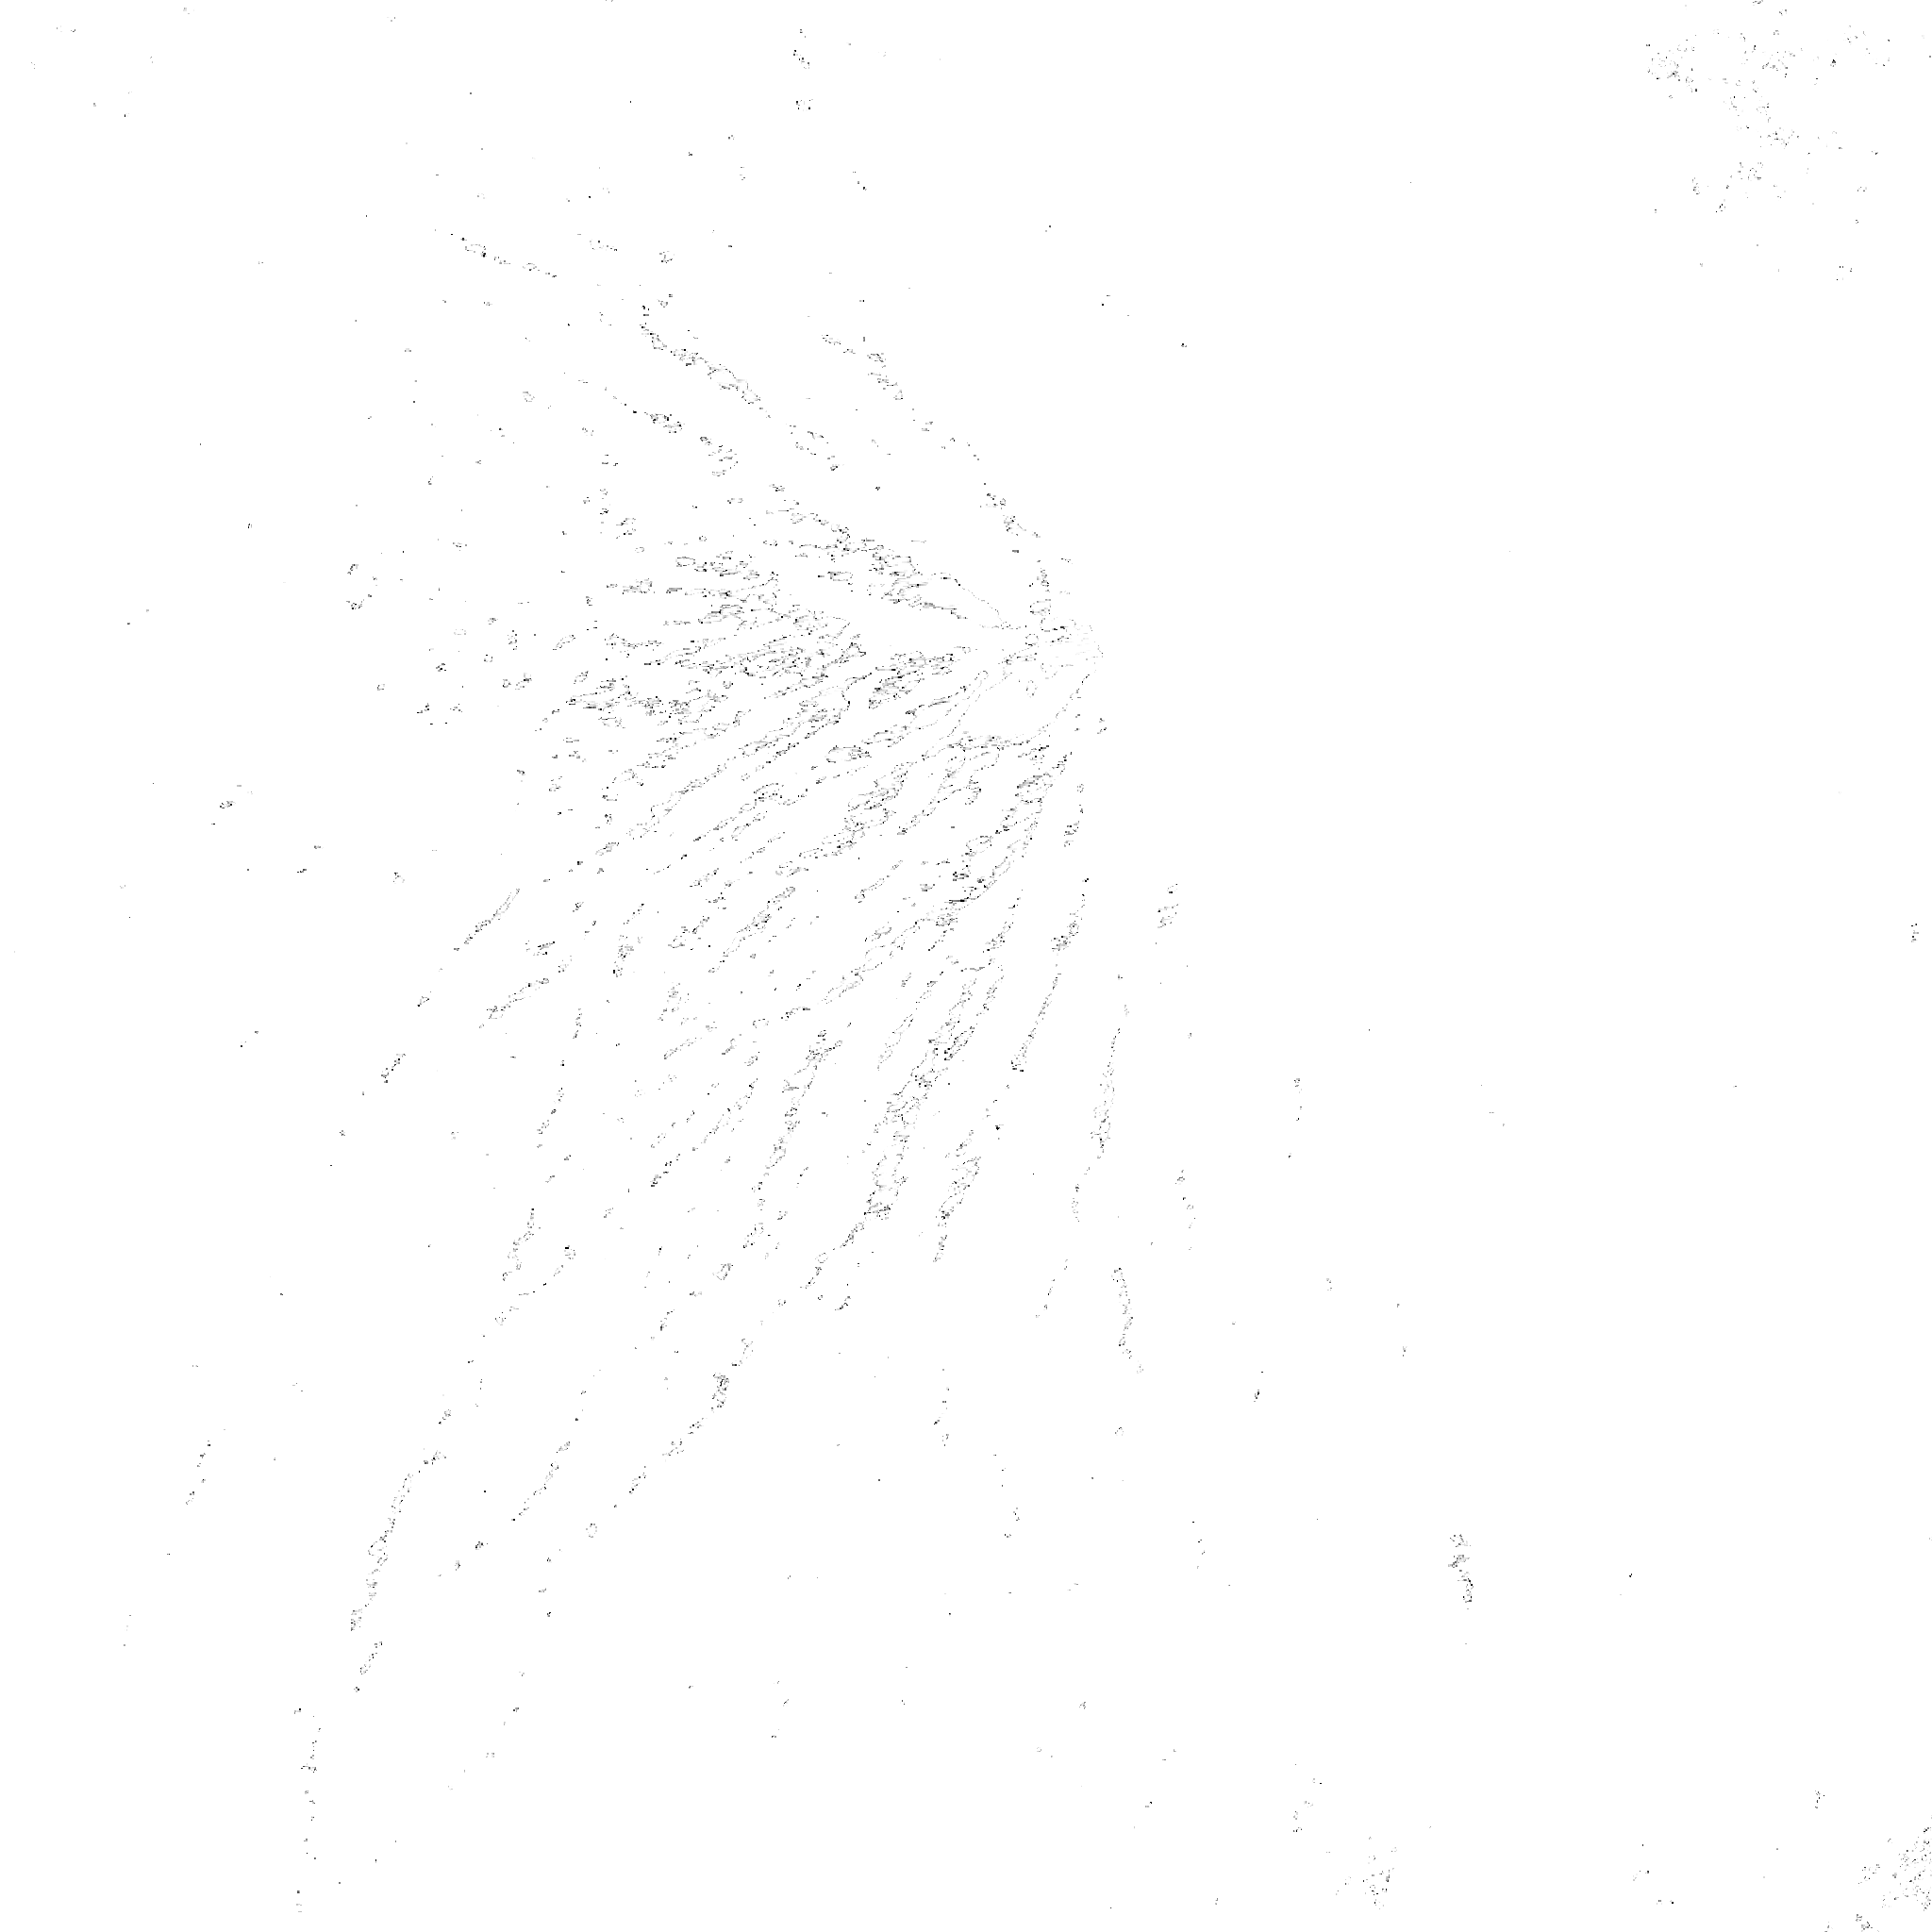

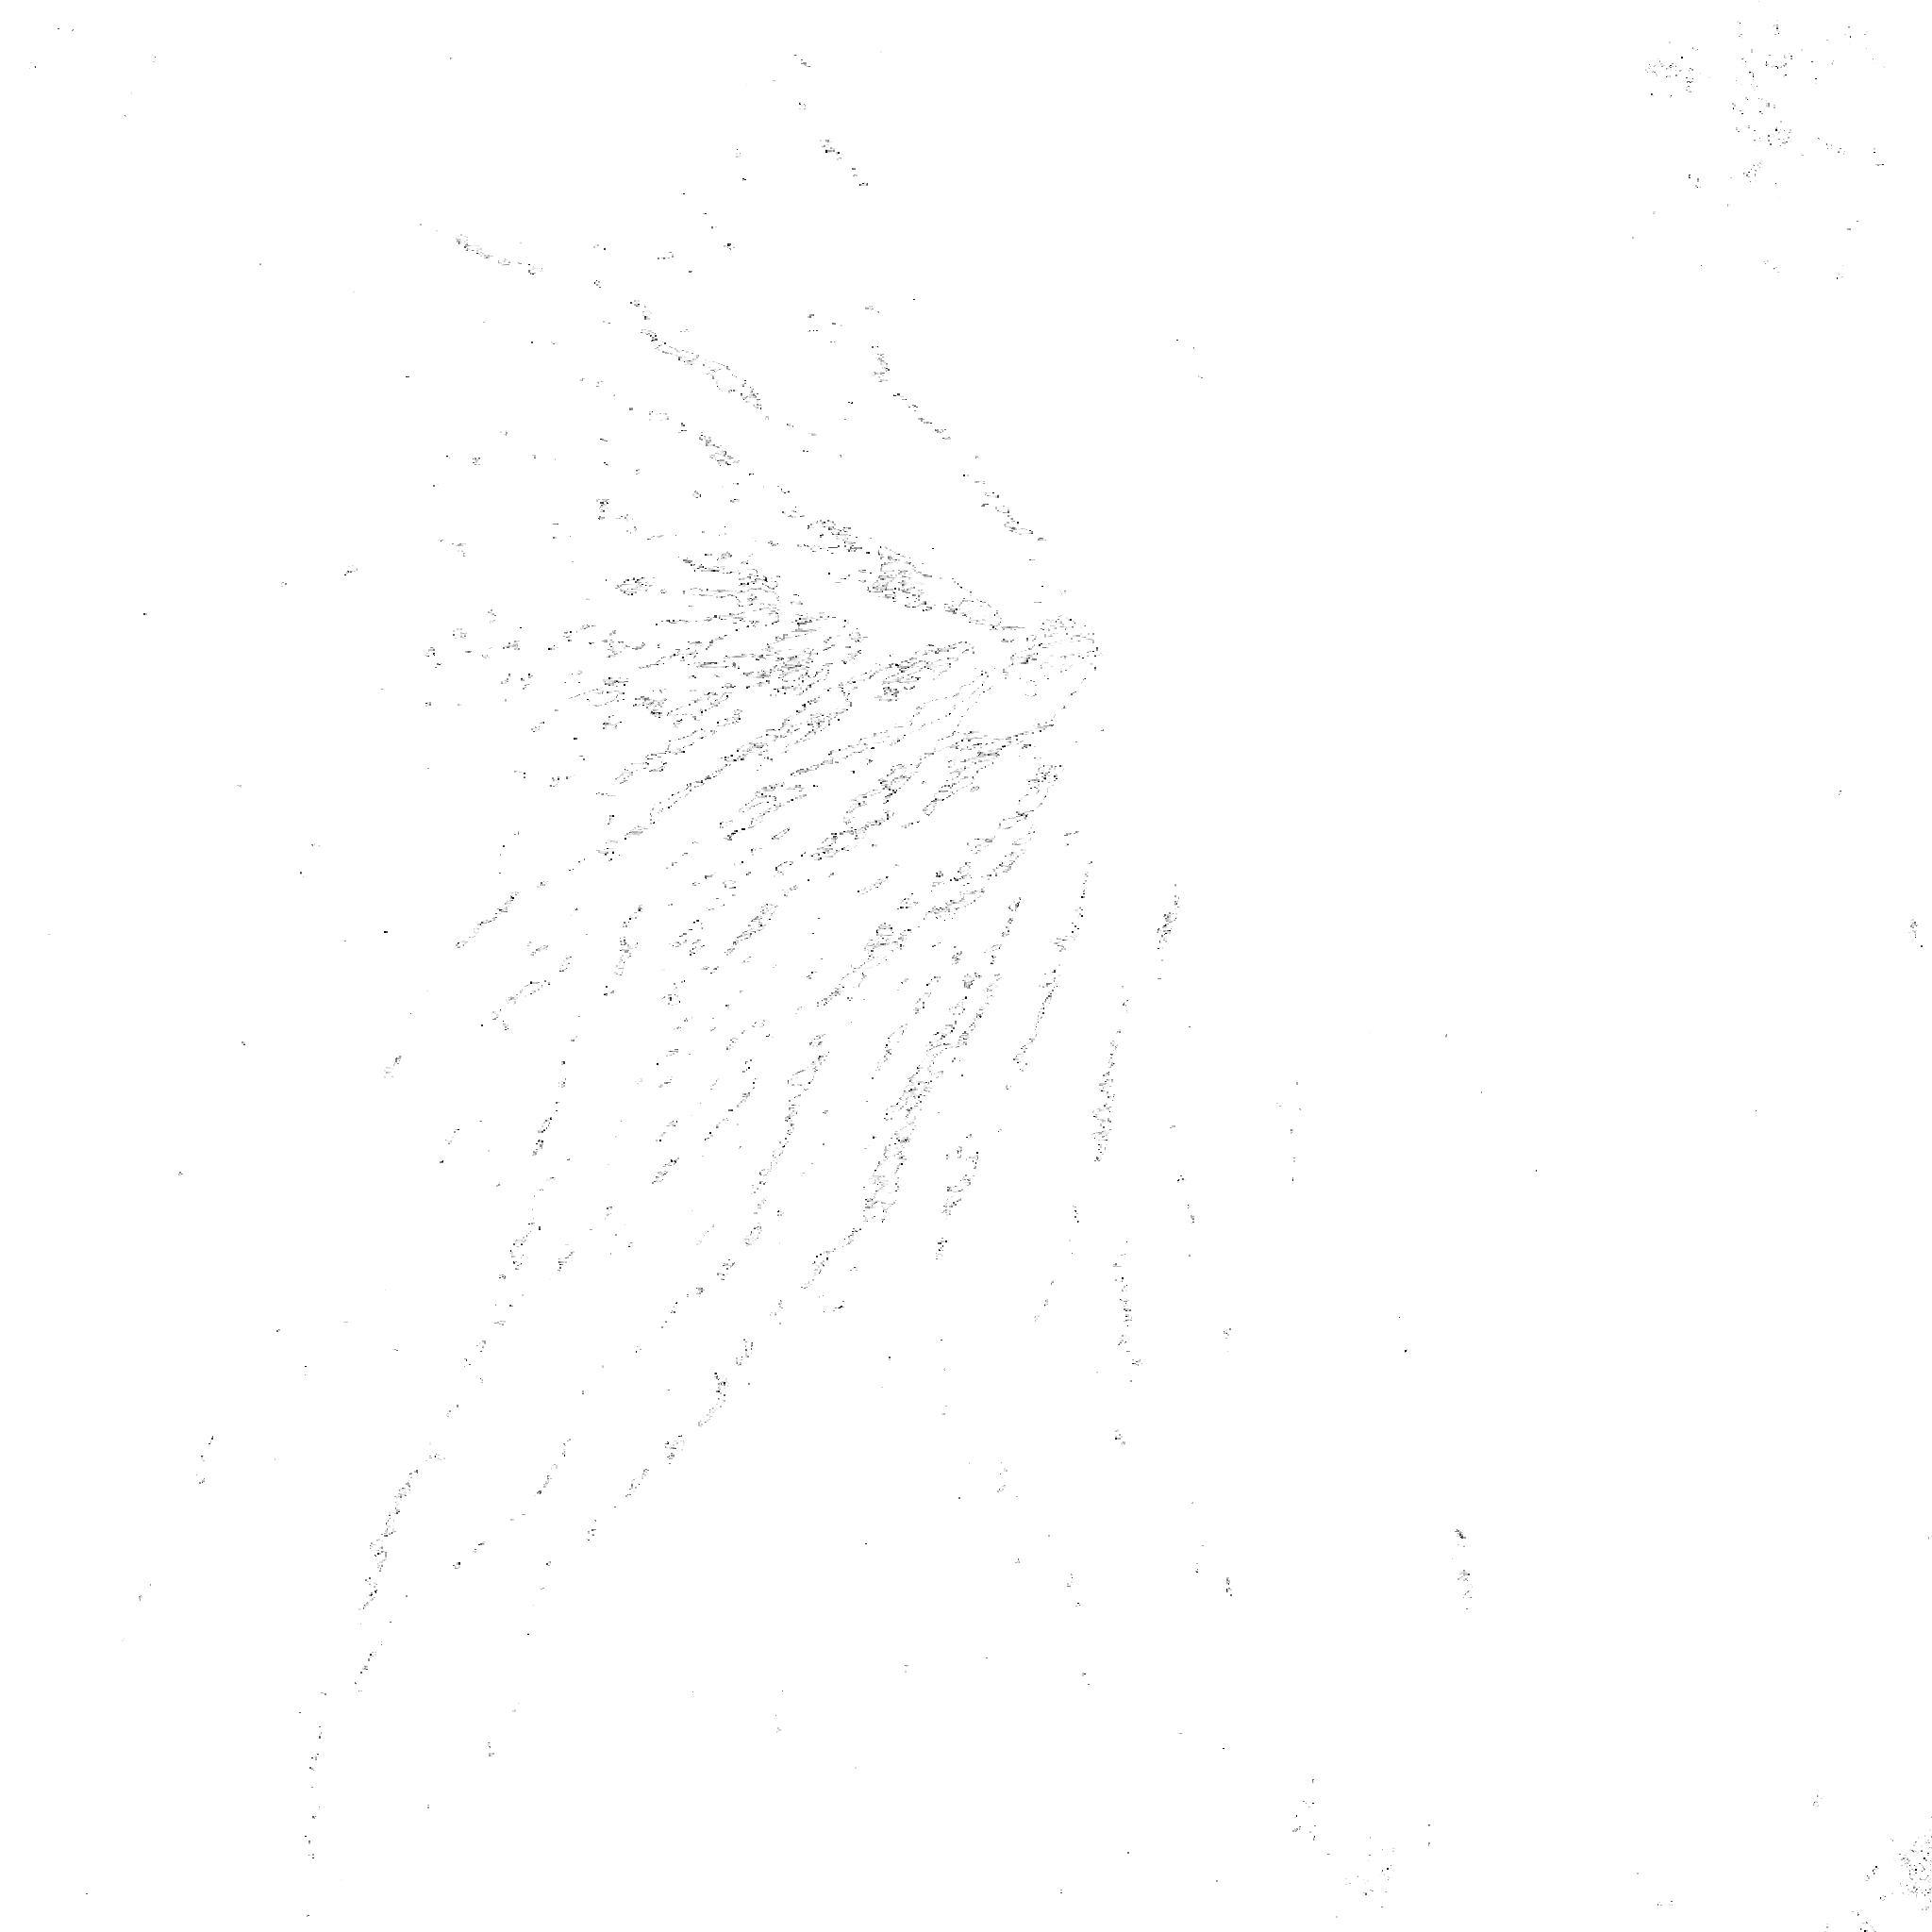

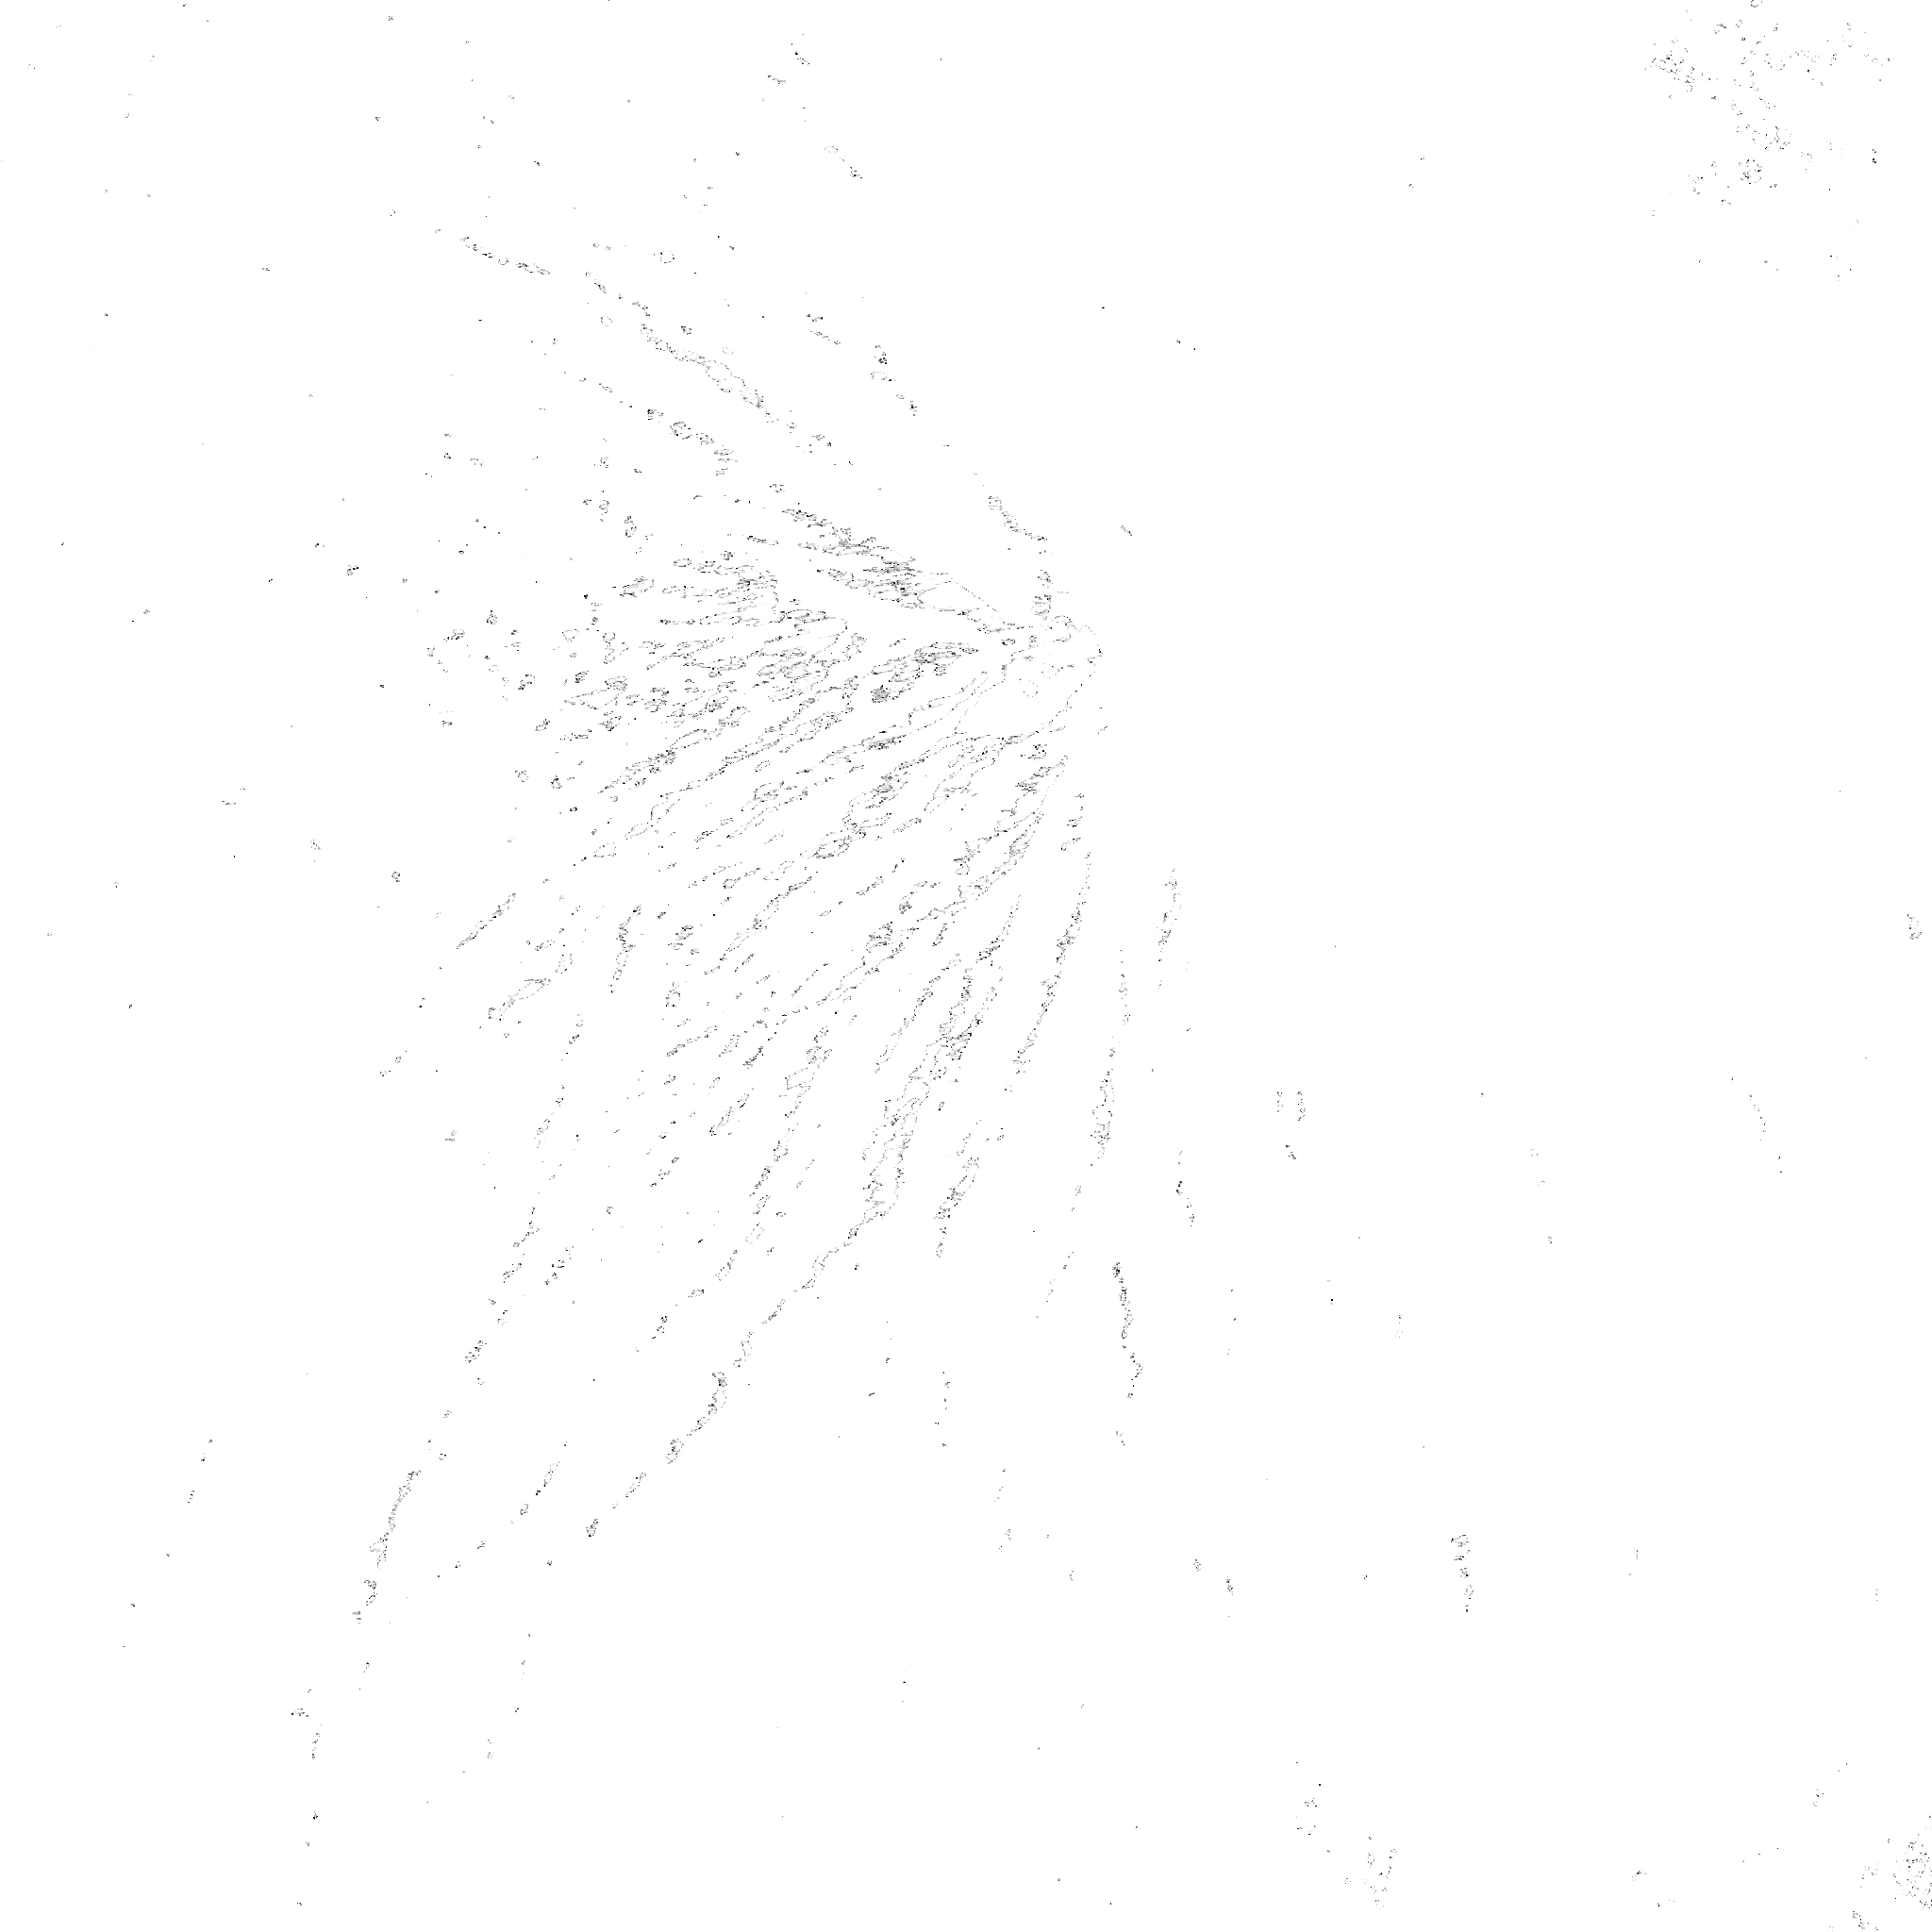

Archivos guardados: ['/content/before_vv_db.png', '/content/during_vv_db.png', '/content/after_vv_db.png']


In [37]:
import ee, os, requests
from IPython.display import Image, display

# --- Usa tu mismo AOI y ventanas ---
aoi = ee.Geometry.Rectangle([-90.8, 14.4, -90.7, 14.5])
dates = {
    "before":  ("2025-06-01", "2025-06-30"),
    "during":  ("2025-07-01", "2025-07-31"),
    "after":   ("2025-08-01", "2025-10-05"),
}

def s1_vv_db(aoi, start, end, orbit="ASCENDING"):
    col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filterBounds(aoi)
           .filterDate(start, end)
           .filter(ee.Filter.eq("instrumentMode","IW"))
           .filter(ee.Filter.eq("orbitProperties_pass", orbit))
           .filter(ee.Filter.listContains("transmitterReceiverPolarisation","VV"))
           .select("VV"))
    # Compuesto robusto y máscara para evitar log(0)
    img = col.median()
    img_pos = img.updateMask(img.gt(1e-4))
    return img_pos.log10().multiply(10).rename("VV_dB").clip(aoi), col.size()

# Imágenes en dB
before_db, nB = s1_vv_db(aoi, *dates["before"])
during_db, nD = s1_vv_db(aoi, *dates["during"])
after_db,  nA = s1_vv_db(aoi, *dates["after"])
print("Imágenes usadas -> before:", nB.getInfo(), "during:", nD.getInfo(), "after:", nA.getInfo())

# Estiramiento fijo (coherente entre las 3)
vis = {"min": -18, "max": 0, "format": "png"}

def save_png(img, fname, dims=2048):
    url = img.getThumbURL({**vis, "region": aoi, "dimensions": dims})
    r = requests.get(url, stream=True)
    with open(fname, "wb") as f:
        f.write(r.content)
    return fname

# Guardar y mostrar
paths = []
paths.append(save_png(before_db, "/content/before_vv_db.png"))
paths.append(save_png(during_db, "/content/during_vv_db.png"))
paths.append(save_png(after_db,  "/content/after_vv_db.png"))

for p in paths:
    display(Image(filename=p))
print("Archivos guardados:", paths)


## Publication-style visuals

We blend each VV(dB) composite (and the Δ dB layers) over **hillshade** to emphasize the cone’s gullies and ridges.  
Each figure includes a **color bar** and a **scale bar**, matching the style commonly used in papers.


In [36]:
# === COMPARATIVA ANTES / DURANTE / DESPUÉS (Sentinel-1 VV, dB) ===
import ee, geemap

Map = geemap.Map(center=[14.45, -90.75], zoom=11)  # ajusta si quieres
aoi = ee.Geometry.Rectangle([-90.8, 14.4, -90.7, 14.5])  # mismo AOI de tu serie

# --- Ventanas de tiempo (ajústalas si hace falta) ---
dates = {
    "before":  ("2025-06-01", "2025-06-30"),
    "during":  ("2025-07-01", "2025-07-31"),  # enjambre de julio
    "after":   ("2025-08-01", "2025-10-05"),
}

# --- Funciones auxiliares ---
def s1_vv_db(aoi, start, end, orbit="ASCENDING"):
    col = (ee.ImageCollection("COPERNICUS/S1_GRD")
           .filterBounds(aoi)
           .filterDate(start, end)
           .filter(ee.Filter.eq("instrumentMode", "IW"))
           .filter(ee.Filter.eq("orbitProperties_pass", orbit))
           .filter(ee.Filter.listContains("transmitterReceiverPolarisation", "VV"))
           .select("VV"))

    img = col.median()

    # ⚠️ Evitar log(0): enmascara píxeles <= 0 antes del log10
    img_pos = img.updateMask(img.gt(0))

    db = img_pos.log10().multiply(10).rename("VV_dB")

    # No uses ee.Number.infinity; ya están enmascarados los no válidos
    return db.clip(aoi), col.size()


def diff(imgA_db, imgB_db):
    # devuelve B - A (cambio en dB)
    return imgB_db.subtract(imgA_db).rename("dB_change")

# --- Construir compositos ---
before_db, nB = s1_vv_db(aoi, *dates["before"])
during_db, nD = s1_vv_db(aoi, *dates["during"])
after_db,  nA = s1_vv_db(aoi, *dates["after"])

print("Imágenes usadas -> before:", nB.getInfo(), "during:", nD.getInfo(), "after:", nA.getInfo())

# --- Diferencias ---
chg_BD = diff(before_db, during_db)  # durante - antes
chg_DA = diff(during_db, after_db)   # después - durante

# --- Visualización ---
vis_db   = {"min": -18, "max": 0}                          # backscatter típico VV en dB
vis_diff = {"min": -3, "max": 3,
            "palette": ["#57007f","#3c53a1","#4fb3ff","#e6f5ff","#fff5e6","#ffb84f","#e65c3c","#7f0000"]}

Map.addLayer(before_db, vis_db,  "ANTES (VV dB)")
Map.addLayer(during_db, vis_db,  "DURANTE (VV dB)")
Map.addLayer(after_db,  vis_db,  "DESPUÉS (VV dB)")
Map.addLayer(chg_BD,    vis_diff,"CAMBIO (DURANTE − ANTES) [dB]")
Map.addLayer(chg_DA,    vis_diff,"CAMBIO (DESPUÉS − DURANTE) [dB]")

# --- Extraer “placas/parches” de cambio significativo ---
# Umbral simple (|Δ| >= 1.5 dB) + limpieza morfológica + mínimo tamaño
THRESH_DB = 1.5      # ajusta sensibilidad
MIN_PIX   = 30       # tamaño mínimo (en pixeles de 10m) para filtrar ruido
SCALE     = 20       # m/pixel para vectorizar sin consumir mucha cuota

abs_change = chg_DA.abs()  # puedes cambiar a chg_BD.abs() si te interesa julio específicamente
mask_big  = abs_change.gte(THRESH_DB)

# quitar sal y pimienta (aperturas/cierres simples)
kernel    = ee.Kernel.square(1)
mask_clean= (mask_big.focal_max(kernel=kernel, iterations=1)
                   .focal_min(kernel=kernel, iterations=1))

# filtrar por tamaño: cuenta pixeles conectados y deja solo los grandes
labeled   = mask_clean.connectedPixelCount(100, True)  # 8-conectividad
large_cc  = mask_clean.updateMask(labeled.gte(MIN_PIX))

# vectorizar
vectors = large_cc.selfMask().reduceToVectors(
    geometry=aoi,
    scale=SCALE,
    geometryType='polygon',
    labelProperty='change',
    maxPixels=1e13,
    bestEffort=True
)

# estilizar polígonos
poly_style = {"color":"#ffcc00", "fillColor":"00000000", "width":2}
Map.addLayer(vectors.style(**poly_style), {}, f"Parche cambio ≥ {THRESH_DB} dB")

# marcador AOI y mostrar mapa
Map.addLayer(aoi, {"color":"red"}, "AOI", False)
Map


Imágenes usadas -> before: 5 during: 5 after: 9


Map(center=[14.45, -90.75], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

## Results — What the maps show

- **Topography-controlled pattern.** Anomalies trace the cone’s **radial channels**, consistent with **slope processes** (small rockfalls/raveling, moisture changes), not a straight surface-rupturing fault.  
- **Where it’s strongest.** Densest change on the **S–SW–W flanks** along major drainages; the NE sector is quieter.  
- **Temporal behavior.** **During−Before** shows the widest footprint; **After−During** contracts, with persistence near the summit and channel heads.  
- **No continuous linear rupture** across the AOI in these GRD products.


Imágenes usadas -> BEFORE: 5 (ASCENDING), DURING: 5 (ASCENDING), AFTER: 9 (ASCENDING)
Archivos guardados:
/content/before_vv_db.png
/content/during_vv_db.png
/content/after_vv_db.png


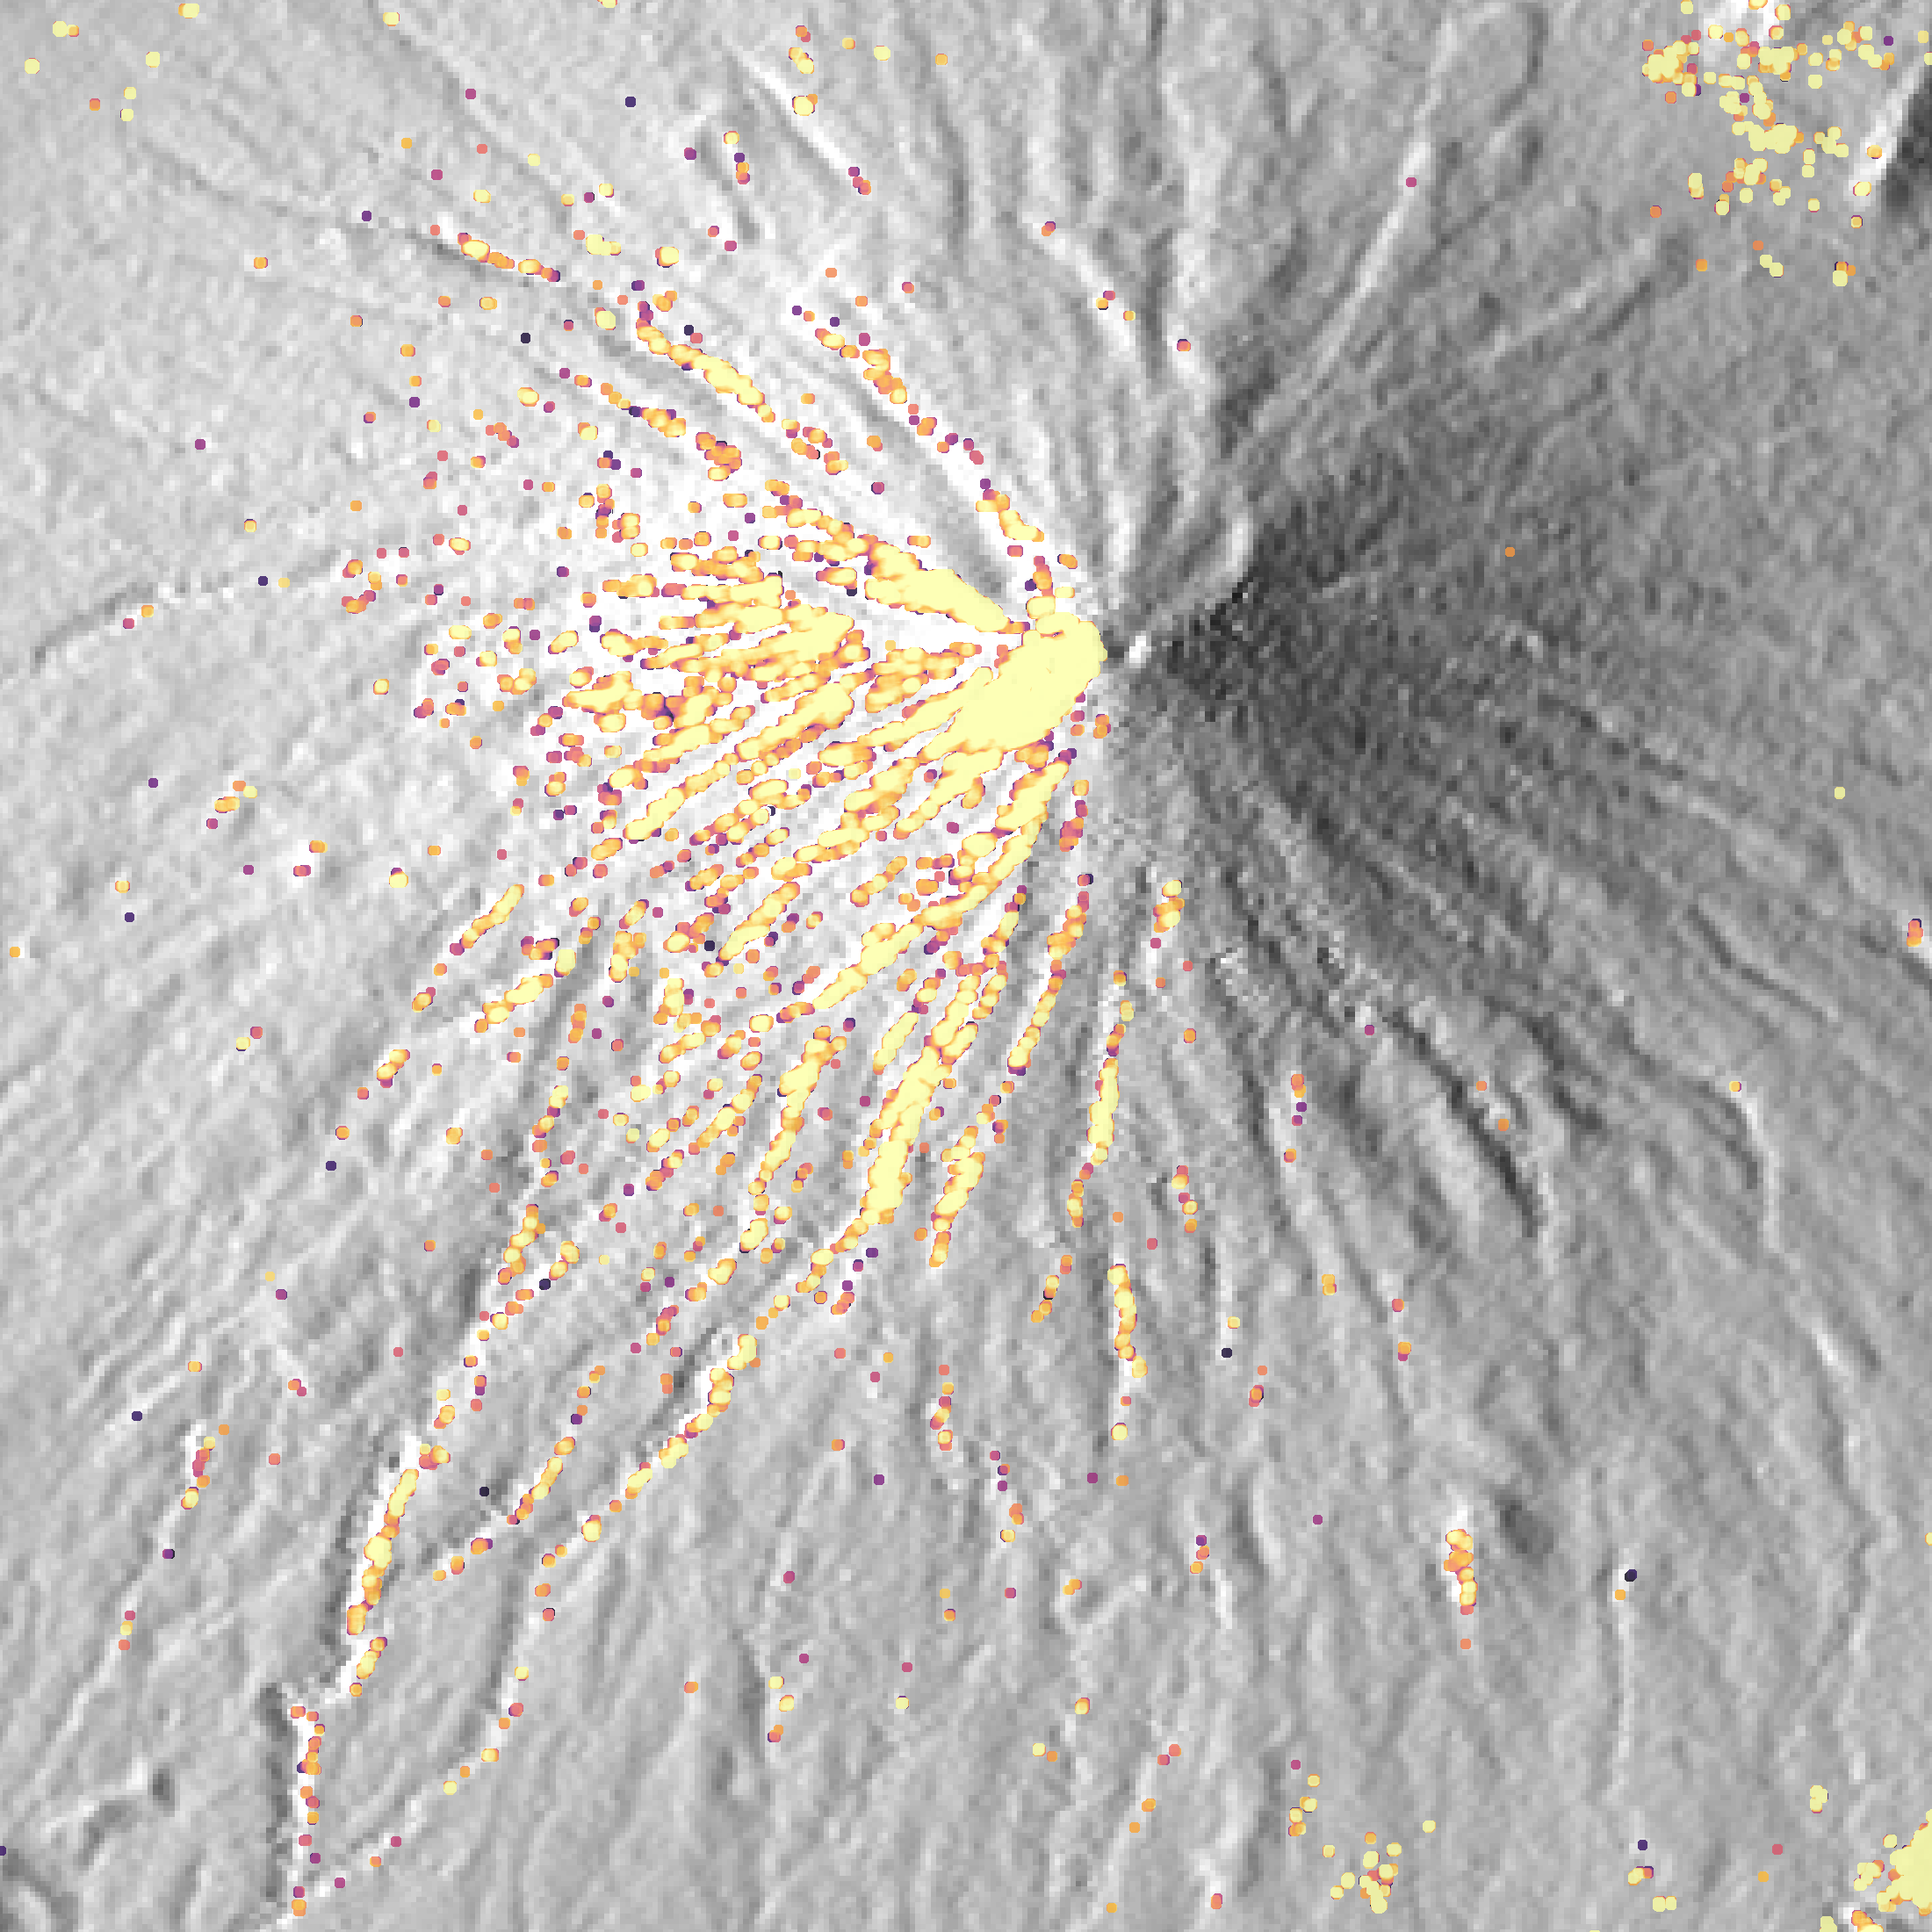

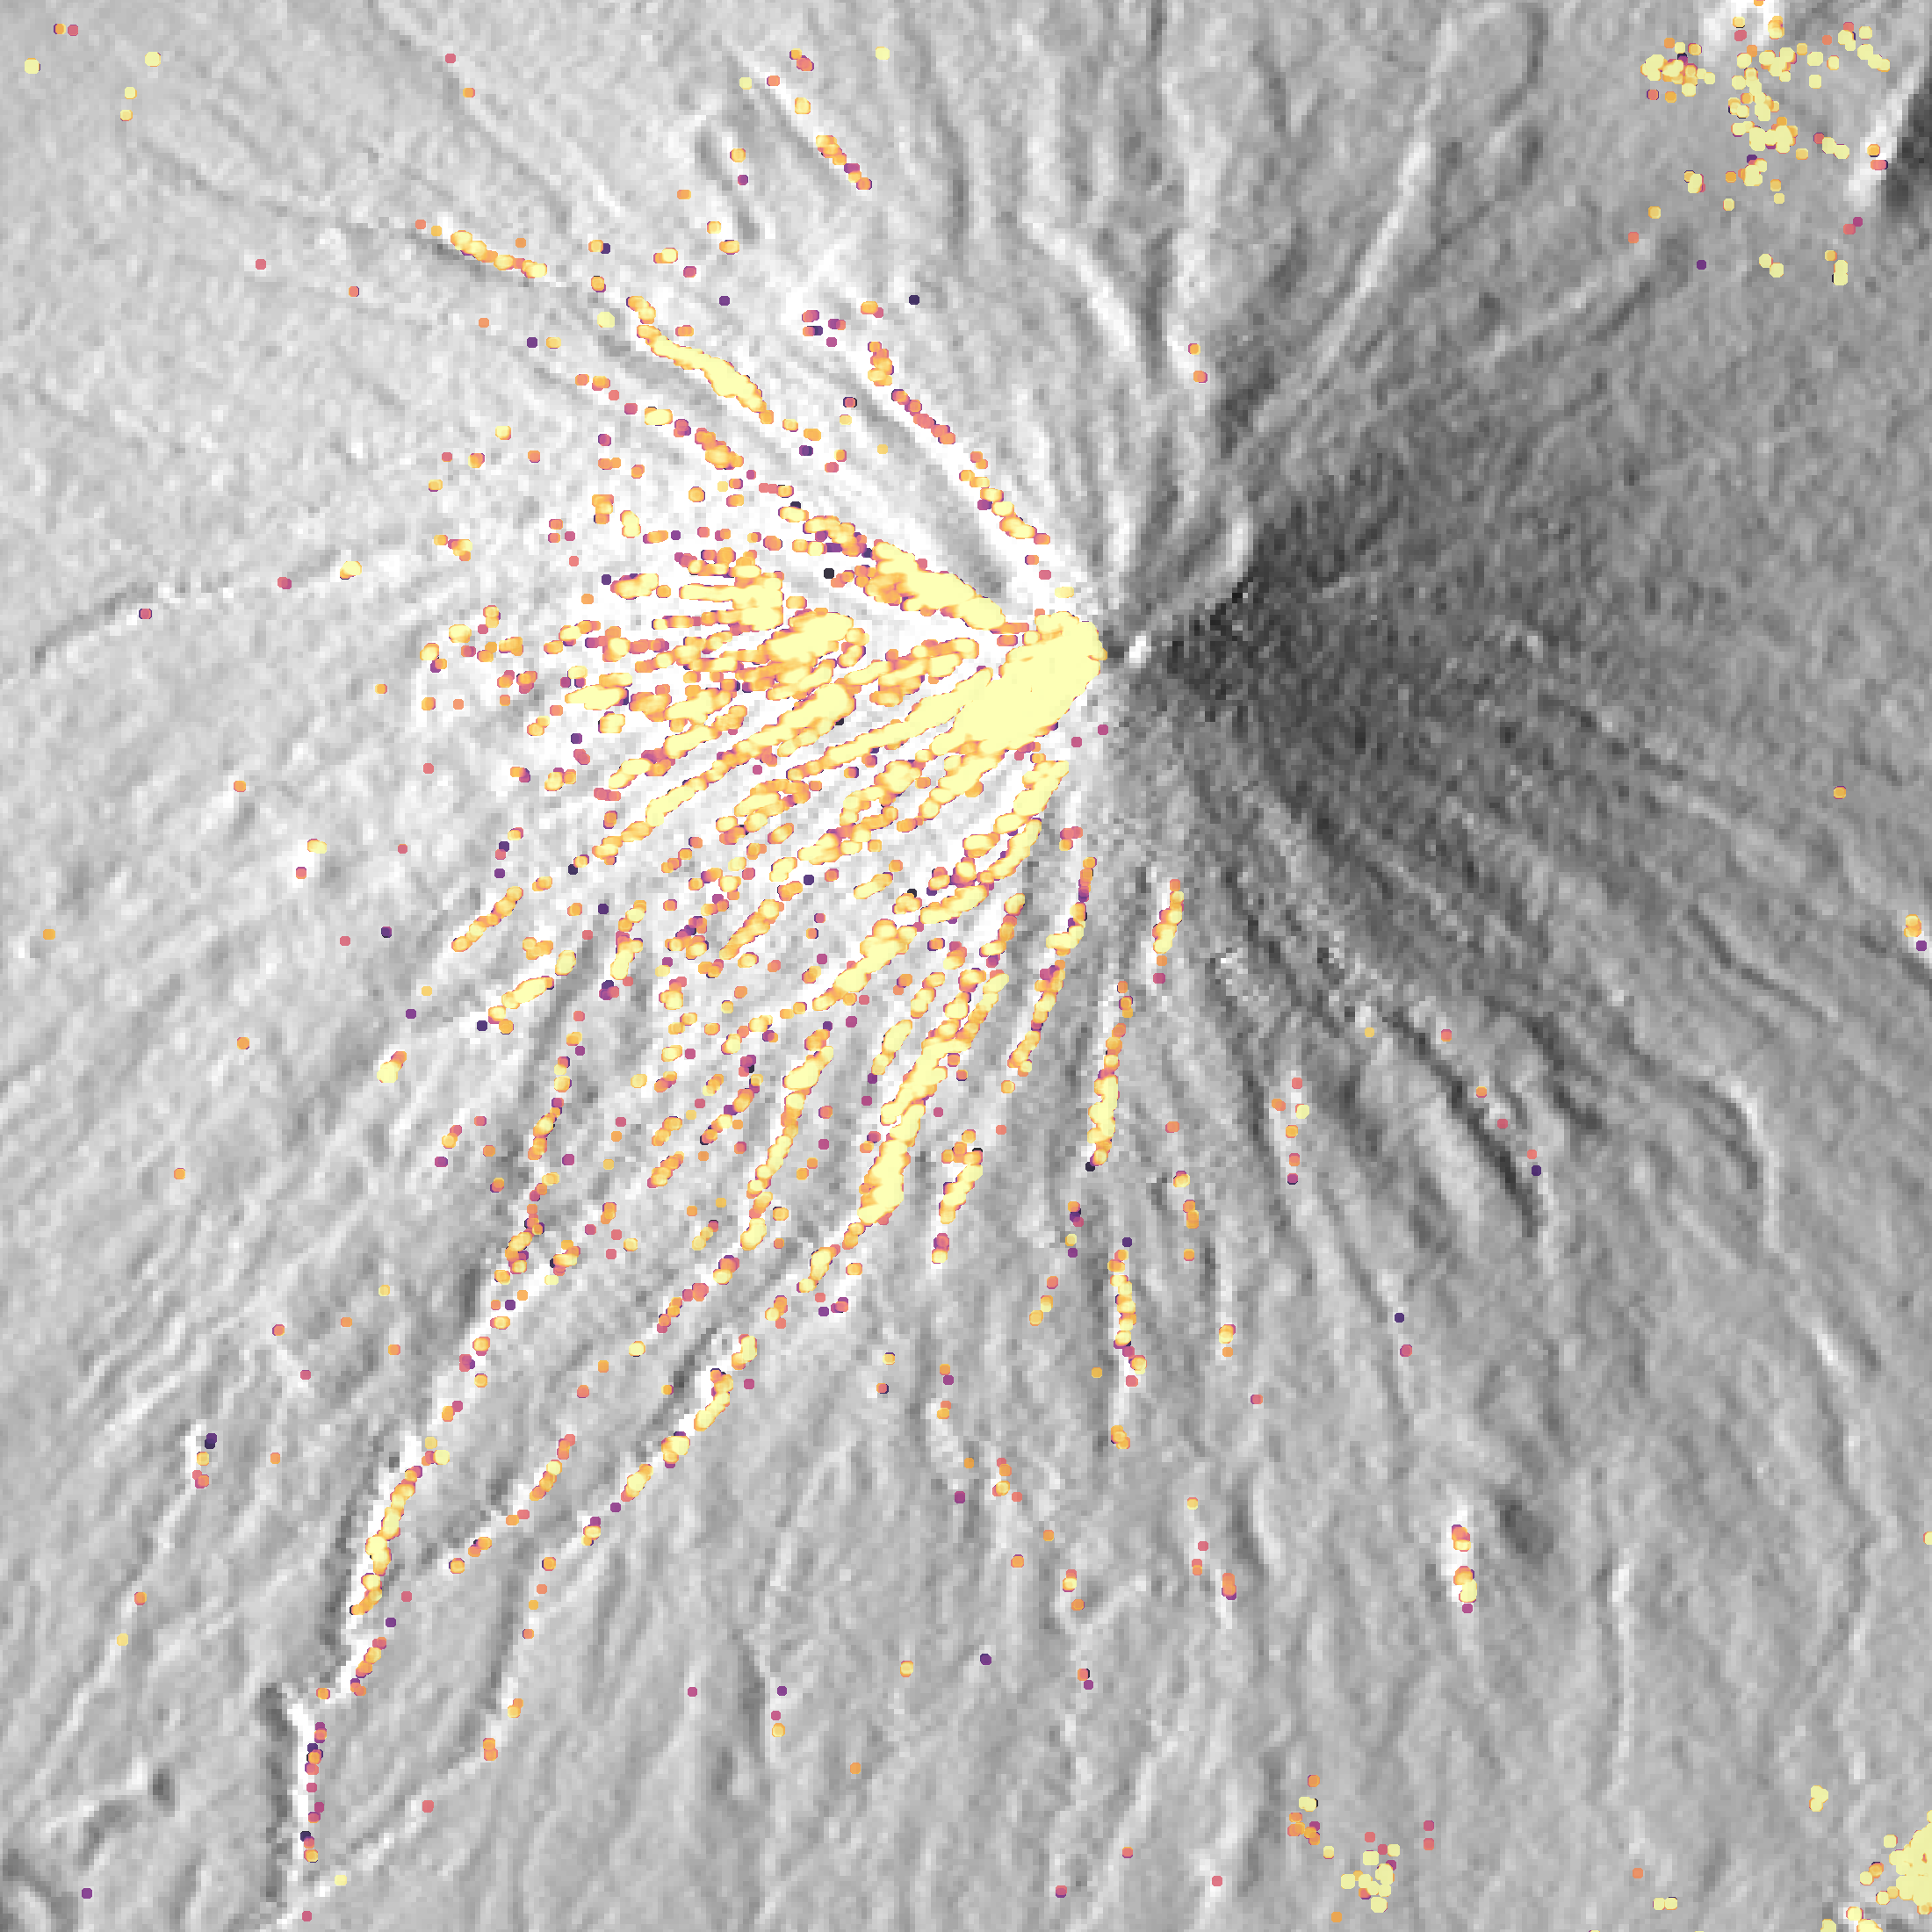

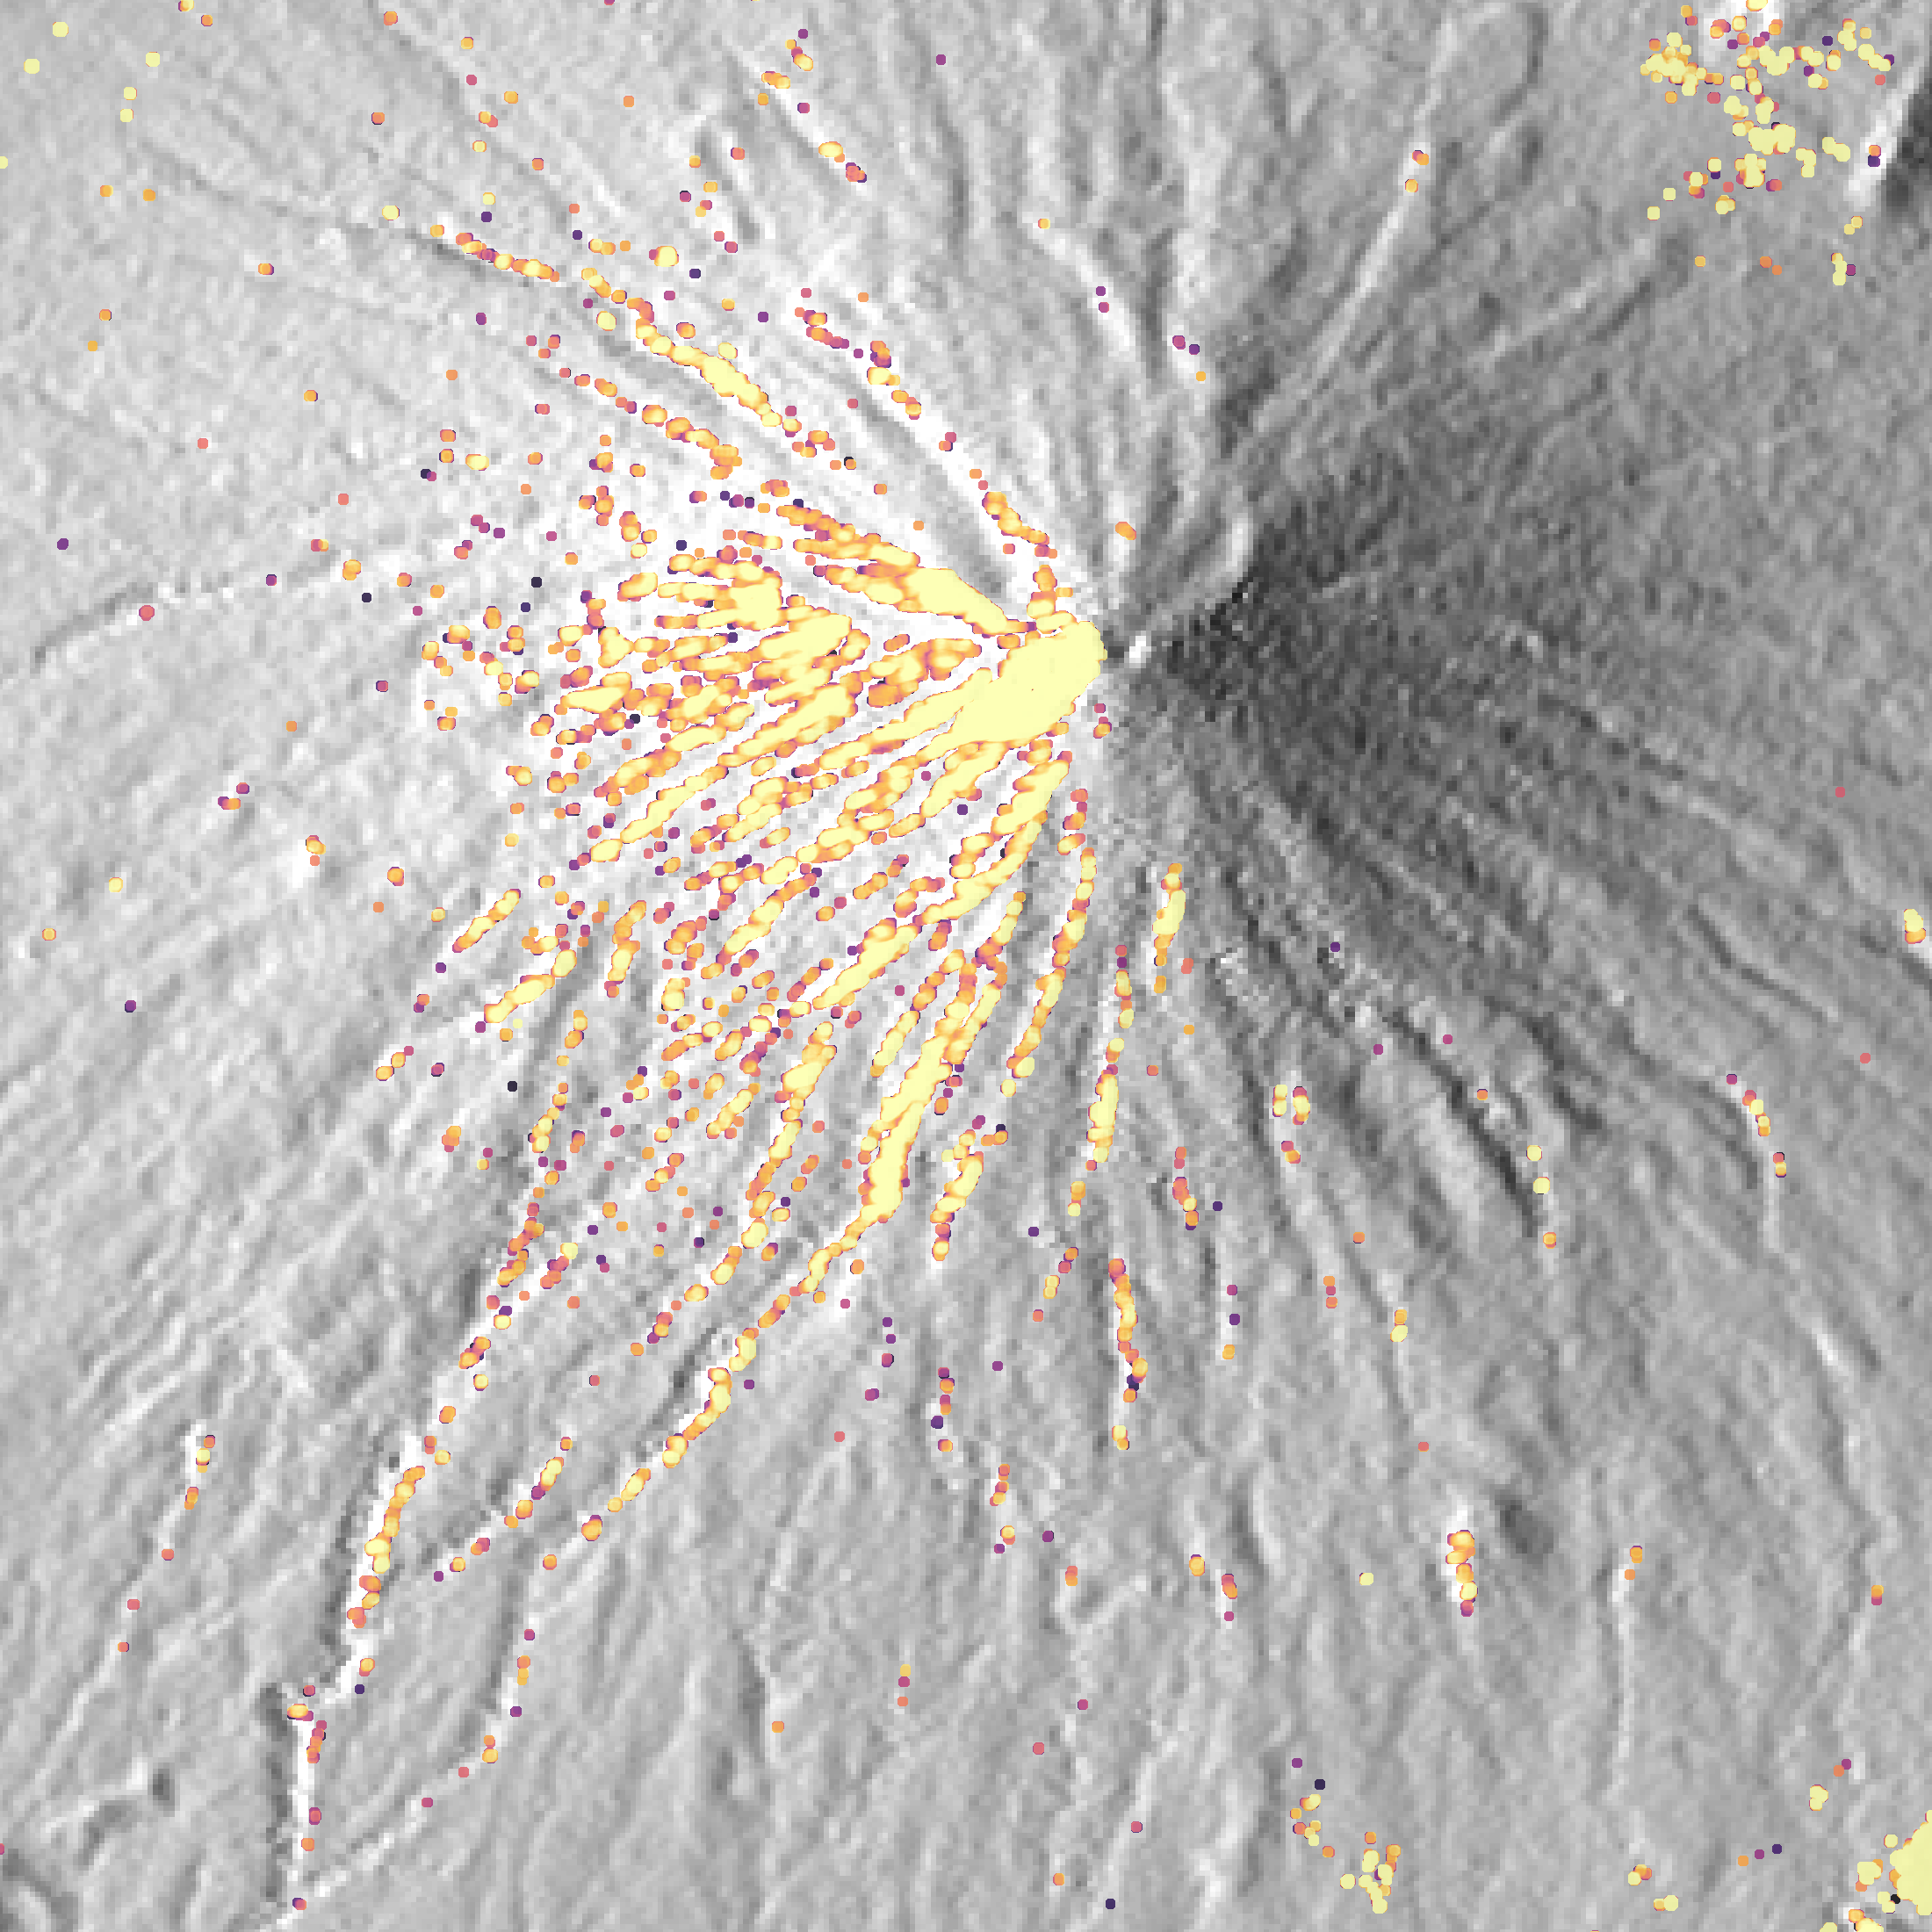

In [41]:
# === GENERAR PNGs: ANTES / DURANTE / DESPUÉS (Sentinel-1 VV en dB, “look paper”) ===
import os, io, math, requests
from IPython.display import Image, display
from PIL import Image as PILImage
import ee

# --- AOI y ventanas (usa tu AOI si ya existe, si no define este por default) ---
try:
    AOI
except NameError:
    AOI = ee.Geometry.Rectangle([-90.8, 14.4, -90.7, 14.5])  # Sacatepéquez por defecto

DATES = {
    "before":  ("2025-06-01", "2025-06-30"),
    "during":  ("2025-07-01", "2025-07-31"),
    "after":   ("2025-08-01", "2025-10-05"),
}
PREFERRED_ORBIT = "ASCENDING"  # se intentará este primero, si no hay datos se usa DESCENDING
DIMS = 2200                    # tamaño del PNG (lado mayor en px)
SMOOTH_M = 30                  # radio de suavizado (m) para reducir speckle

# --- Utilidades S1 y descarga de thumbnail ---
def s1_vv_collection(aoi, start, end, orbit):
    return (ee.ImageCollection("COPERNICUS/S1_GRD")
            .filterBounds(aoi)
            .filterDate(start, end)
            .filter(ee.Filter.eq("instrumentMode","IW"))
            .filter(ee.Filter.eq("orbitProperties_pass", orbit))
            .filter(ee.Filter.listContains("transmitterReceiverPolarisation","VV"))
            .select("VV"))

def s1_vv_db(aoi, start, end, prefer_orbit="ASCENDING", smooth_m=30):
    """Devuelve (img_db, n_imgs, orbit_usado). Prueba prefer_orbit y, si no hay, el opuesto."""
    orbits = [prefer_orbit, "DESCENDING" if prefer_orbit=="ASCENDING" else "ASCENDING"]
    for orb in orbits:
        col = s1_vv_collection(aoi, start, end, orb)
        n = col.size().getInfo()
        if n > 0:
            img = col.median().updateMask(col.median().gt(1e-4))  # evita log(0)
            if smooth_m and smooth_m > 0:
                img = img.focal_mean(radius=smooth_m, units="meters")
            db = img.log10().multiply(10).rename("VV_dB").clip(aoi)
            return db, n, orb
    raise RuntimeError(f"Sin escenas S1 VV en {start}..{end} (ASC/DESC) para el AOI.")

def style_db(img_db):
    # paleta perceptual suave y consistente entre épocas
    return img_db.visualize(min=-18, max=0,
                            palette=["#000004","#2c115f","#721f81","#b63679","#ef6c63","#fbb22d","#fcffa4"])

def hillshade_gray(aoi):
    srtm = ee.Image("USGS/SRTMGL1_003")
    hs   = ee.Terrain.hillshade(srtm)  # 0..255
    g = hs.divide(255).clip(aoi)
    return ee.Image.cat(g, g, g).multiply(255).toByte()  # RGB gris

def blend_base_overlay(base_rgb, overlay_rgb, overlay_opacity=0.80):
    overlay_vis = overlay_rgb.updateMask(overlay_rgb.unitScale(0,255).select(0).gt(0)).visualize(opacity=overlay_opacity)
    return base_rgb.blend(overlay_vis)

def get_png(image_rgb, region, dims=DIMS):
    url = image_rgb.getThumbURL({"region": region, "dimensions": dims, "format": "png"})
    r = requests.get(url)
    r.raise_for_status()
    return PILImage.open(io.BytesIO(r.content)).convert("RGBA")

# --- Construir imágenes ANTES / DURANTE / DESPUÉS en dB (suavizadas) ---
base = hillshade_gray(AOI)

before_db, nB, orbB = s1_vv_db(AOI, *DATES["before"],  prefer_orbit=PREFERRED_ORBIT, smooth_m=SMOOTH_M)
during_db, nD, orbD = s1_vv_db(AOI, *DATES["during"],  prefer_orbit=PREFERRED_ORBIT, smooth_m=SMOOTH_M)
after_db,  nA, orbA = s1_vv_db(AOI, *DATES["after"],   prefer_orbit=PREFERRED_ORBIT, smooth_m=SMOOTH_M)
print(f"Imágenes usadas -> BEFORE: {nB} ({orbB}), DURING: {nD} ({orbD}), AFTER: {nA} ({orbA})")

before_rgb = blend_base_overlay(base, style_db(before_db), 0.80)
during_rgb = blend_base_overlay(base, style_db(during_db), 0.80)
after_rgb  = blend_base_overlay(base, style_db(after_db),  0.80)

# --- Descargar, guardar y mostrar PNGs (mismo encuadre) ---
out_before = "/content/before_vv_db.png"
out_during = "/content/during_vv_db.png"
out_after  = "/content/after_vv_db.png"

img_before = get_png(before_rgb, AOI, DIMS); img_before.save(out_before)
img_during = get_png(during_rgb, AOI, DIMS); img_during.save(out_during)
img_after  = get_png(after_rgb,  AOI, DIMS); img_after.save(out_after)

print("Archivos guardados:")
print(out_before); print(out_during); print(out_after)

display(Image(filename=out_before))
display(Image(filename=out_during))
display(Image(filename=out_after))


## Interpretation

The swarm mainly triggered **slope-controlled responses** on the volcanic flanks: short-lived roughening/wetting along channels and small re-arrangements of loose material.  
Signals **peak during** the swarm and **partly recover after**, as expected for transient shaking effects.


## Reproducibility

Maps were generated from Sentinel-1 GRD (IW/VV) as median composites per time window, with non-positive masking and light speckle smoothing, converted to dB with a fixed stretch, and differenced to produce Δ dB maps. Visualizations are shown over hillshade with color and scale bars.
